In [21]:
from pymongo import MongoClient
import pandas as pd

client = MongoClient()
collection = client['text']['dbcomments']
data = list(collection.find())
df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 6 columns):
_id       476 non-null object
author    476 non-null object
star      476 non-null object
text      476 non-null object
time      476 non-null object
votes     476 non-null object
dtypes: object(6)
memory usage: 22.4+ KB


In [22]:
df.head()

,_id,author,star,text,time,votes
0,5d972d729f60af0884a86bc7,凌睿,allstar50 rating,[或是被第三者插足，或是不受父母待见，或是被辞退，或是父母根本不想把Ta生下来……这群被抛弃...,2018-08-02 10:33:17,9908
1,5d972d759f60af0884a86bc8,西楼尘,allstar40 rating,[最费力的成长留在树上的只有壳，最狰狞的伤口留在皮肤的只有疤。最动人的烟火绽在空中看不到，最...,2018-07-02 17:32:29,21559
2,5d972d759f60af0884a86bc9,咯咯精,allstar40 rating,[如果说爱你，还打你，那一定是说谎；如果爱你，就会像安藤樱一样紧紧抱住你。（沉溺于安藤樱的美...,2018-05-14 19:31:33,4813
3,5d972d759f60af0884a86bca,姨妈的鸭,allstar40 rating,[比起放下手机，这本电影在观影时需要观众做的第一步是：放下三观。],2018-06-23 12:34:42,4642
4,5d972d759f60af0884a86bcb,九只苍蝇撞墙,allstar50 rating,[那些说是枝一直致敬小津的人可以歇歇了。这次他拍了部让小津最深恶痛绝的今村昌平式的蛆虫电影。...,2018-06-11 21:22:12,4818


In [23]:
# 一共包含475条不重复数据
len(df['time'].unique())

475

In [24]:
# 查看各个评分所占百分比
print(df['star'].value_counts())


allstar40 rating    196
allstar50 rating    193
allstar30 rating     51
allstar20 rating     14
comment-time         14
allstar10 rating      8
Name: star, dtype: int64


In [25]:
# 将star转换为星
def switch_star(x):
    if x == 'allstar10 rating':
        x = '1星'
    elif x == 'allstar20 rating':
        x = '2星'
    elif x == 'allstar30 rating':
        x = '3星'
    elif x == 'allstar40 rating':
        x = '4星'
    elif x == 'allstar50 rating':
        x = '5星'
    else:
        x = '无'
    return x
df['star'] = df['star'].apply(switch_star) 
print(df['star'].value_counts())

4星    196
5星    193
3星     51
无      14
2星     14
1星      8
Name: star, dtype: int64


In [26]:
# 绘制成图
from pyecharts import Pie

pie = Pie()
index = df['star'].value_counts().index.tolist()
values = df['star'].value_counts().values.tolist()
pie.add('',index,values,is_label_show=True,legend_orient="vertical",legend_pos='left')
pie

In [34]:
# 将评论内容写入文本
import jieba
with open(r'doubancomments.txt','ab') as f:
    for comment in df['text']:
        comment = ''.join(comment).strip()
        f.write(comment.encode('utf-8'))
        f.write(b'\n')

In [30]:
# 分词
import jieba
import collections
comments = open(r'doubancomments.txt','r',encoding='utf-8').read()
words = jieba.lcut(comments)
result = collections.Counter(words)
word_counts = dict(result)
excludes = [',','的','。','是','\n','了','和','在','“','、','”','也','人','都','有','不',' ','与','但','？',
            '没有','一个','《','》','就','看','，','我','对','被','这','最','他','又','你','上','却','中',
            '让','很','说','到','把','而','（','）','着','更','…','就是','啊','还是','什么','不是','地','这个',
            '：','；','会','用',
           ]
for word in excludes:
    del word_counts[word]
items = list(word_counts.items())
items.sort(key=lambda x:x[1],reverse=True)
data30 = items[:30]
data_index = list(zip(*data30))[0]
data_value = list(zip(*data30))[1]

In [42]:
# 词云展示
from pyecharts import WordCloud
wordcloud = WordCloud('小偷家族')
wordcloud.add('',data_index,data_value,word_szie_range=[60,200])
wordcloud

In [43]:
# 情感分析
from snownlp import SnowNLP
sentiments = []
for comment in df['text']:
    comment = ''.join(comment)
    point = SnowNLP(comment).sentiments
    sentiments.append(point)

In [47]:
df['sentiments'] = sentiments

In [61]:
df[df['sentiments']<0.5]['sentiments'].min()

6.375784999956835e-08

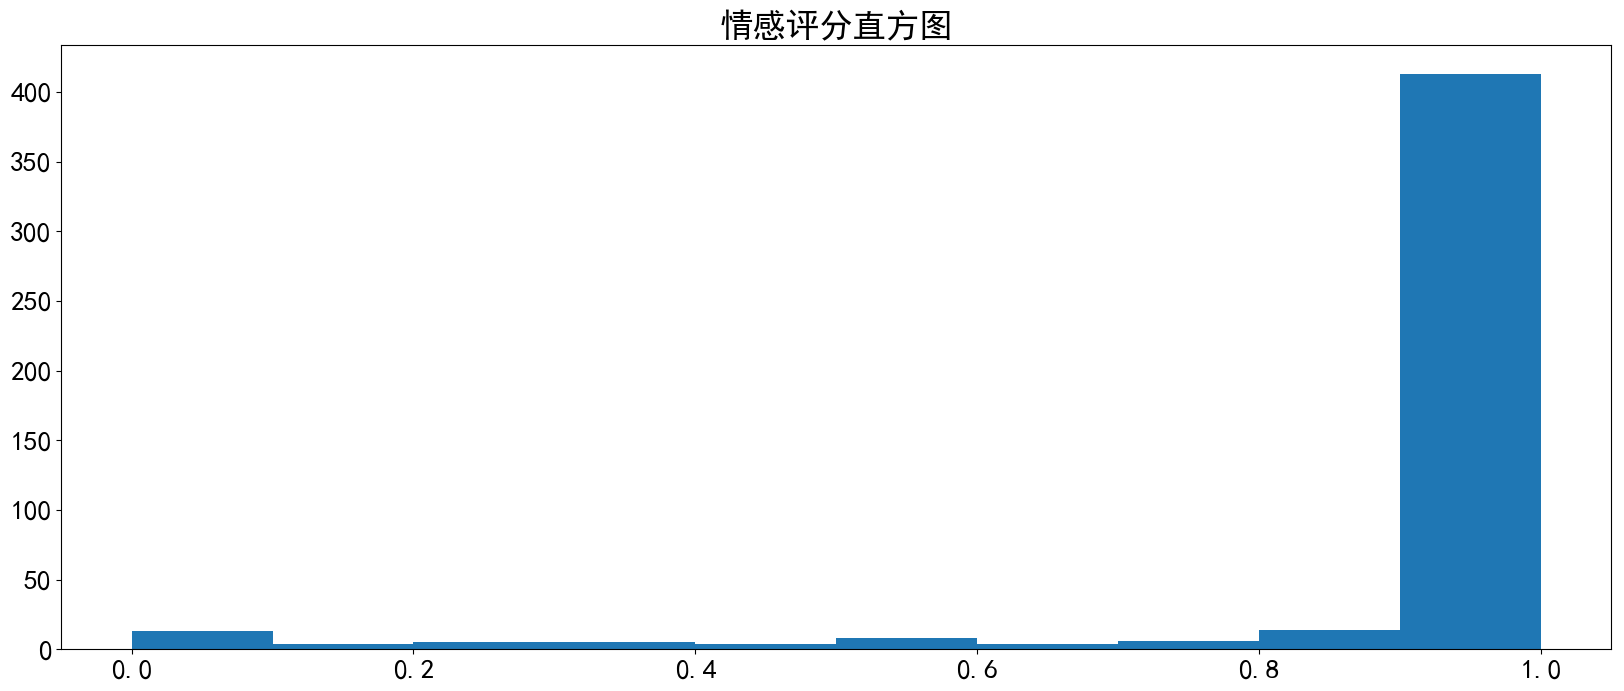

In [65]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']='SimHei'
matplotlib.rcParams['font.size']=20
#组距
d = 0.1
#组数
num_bins=1/d
plt.figure(figsize=(20,8),dpi=100)
plt.hist(list(df['sentiments']),bins=10)
#plt.xticks(list(np.arange(0,1,0.1)))
plt.title('情感评分直方图')
plt.show()

In [70]:
# 评分随时间变化关系
from datetime import datetime
def switch_time(x):
    x = datetime.strptime(x,'%Y-%m-%d %H:%M:%S')
    return x
switch_time(df['time'][0])
df['time'] = df['time'].apply(switch_time)

In [86]:
#jiangcaiyang
df.set_index('time').sort_index().resample('M').count()

,_id,author,star,text,votes,sentiments
time,,,,,,
2018-05-31,33,33,33,33,33,33
2018-06-30,61,61,61,61,61,61
2018-07-31,33,33,33,33,33,33
2018-08-31,326,326,326,326,326,326
2018-09-30,4,4,4,4,4,4
2018-10-31,0,0,0,0,0,0
2018-11-30,1,1,1,1,1,1
2018-12-31,4,4,4,4,4,4
2019-01-31,2,2,2,2,2,2
